# Written by Nina Nurrahmawati
# for NYU CUSP PUI

In [1]:
from __future__  import print_function, division
import pylab as pl
import pandas as pd
import numpy as np
from urllib.request import urlopen
import matplotlib.pylab as plt
import io
%pylab inline
import scipy.stats as st
import datetime as dt
import seaborn

Populating the interactive namespace from numpy and matplotlib


/Applications/anaconda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## IDEA:
People usually have daily routine and tighter schedule in the weekdays, therefore they tend to commute in the weekdays. On the weekend, people do not have occasional trip distribution pattern. I assume that people will go to further place during weekend. Therefore, shorter distance trips are less likely to happens on weekend than longer distance trips.

### NULL HYPOTHESIS:
The ratio of long distance trips in the weekend is less than or equal to the short distance trips on the weekdays.

_$H_0$_ : $\frac{L_{\mathrm{weekend}}}{L_{\mathrm{total}}} <= \frac{S_{\mathrm{weekend}}}{S_{\mathrm{total}}}$

_$H_1$_ : $\frac{L_{\mathrm{weekend}}}{L_{\mathrm{total}}} > \frac{S_{\mathrm{weekend}}}{S_{\mathrm{total}}}$


#### Significance level  $\alpha=0.05$



In [2]:
# download data
url = urlopen('https://s3.amazonaws.com/tripdata/201501-citibike-tripdata.zip')
df = pd.read_csv(io.BytesIO(url.read()), compression='zip', sep=',')

In [3]:
# set date
df['date'] = pd.to_datetime(df['starttime'])
df.head(2)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,date
0,1346,1/1/2015 0:01,1/1/2015 0:24,455,1 Ave & E 44 St,40.750020,-73.969053,265,Stanton St & Chrystie St,40.722293,-73.991475,18660,Subscriber,1960.0,2,2015-01-01 00:01:00
1,363,1/1/2015 0:02,1/1/2015 0:08,434,9 Ave & W 18 St,40.743174,-74.003664,482,W 15 St & 7 Ave,40.739355,-73.999318,16085,Subscriber,1963.0,1,2015-01-01 00:02:00


In [4]:
df.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender', 'date'],
      dtype='object')

In [5]:
df.drop(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'end station id', 'end station name', 'bikeid', 'usertype',
       'birth year'], axis=1, inplace=True)

In [6]:
df.head(2)

,start station latitude,start station longitude,end station latitude,end station longitude,gender,date
0,40.750020,-73.969053,40.722293,-73.991475,2,2015-01-01 00:01:00
1,40.743174,-74.003664,40.739355,-73.999318,1,2015-01-01 00:02:00


In [7]:
# merge and drop location data
df.loc[:,"start_location"] = "(" + df["start station latitude"].map(str) + "," + " " + df["start station longitude"].map(str) + ")"
df.loc[:,"stop_location"] = "(" + df["end station latitude"].map(str) + "," + " " + df["end station longitude"].map(str) + ")"
df.loc[:,"start_location"] = df.loc[:,"start_location"].map(eval)
df.loc[:,"stop_location"] = df.loc[:,"stop_location"].map(eval)
df.drop(['start station latitude', 'start station longitude',
       'end station latitude', 'end station longitude'], axis=1, inplace=True)
df.head(2)

,gender,date,start_location,stop_location
0,2,2015-01-01 00:01:00,"(40.75001986, -73.96905301)","(40.72229346, -73.99147535)"
1,1,2015-01-01 00:02:00,"(40.74317449, -74.00366443)","(40.73935542, -73.99931783)"


In [8]:
# need to install geopy, I'm using this to measure distance
import geopy
from geopy.distance import vincenty
def distance(df):
    return vincenty(df["start_location"],df["stop_location"]).miles

df["distance"] = df.apply(distance, axis=1)

In [9]:
df.head(2)

,gender,date,start_location,stop_location,distance
0,2,2015-01-01 00:01:00,"(40.75001986, -73.96905301)","(40.72229346, -73.99147535)",2.246187
1,1,2015-01-01 00:02:00,"(40.74317449, -74.00366443)","(40.73935542, -73.99931783)",0.348548


In [10]:
# check the distance statistics
df.distance.describe()

count    285552.000000
mean          0.907267
std           0.633454
min           0.000000
25%           0.487272
50%           0.745605
75%           1.134095
max           5.882993
Name: distance, dtype: float64

In [11]:
# set long distance threshold, in this case I choose trip that below the mean of the trip (0.90 miles)
avg = df.distance.mean()
# separate short distance and long distance
# long distance trip = above distance mean
# short distance trip = below distance mean

short = df[df["distance"] < avg]
long = df[df["distance"] > avg]
short.head(2)

,gender,date,start_location,stop_location,distance
1,1,2015-01-01 00:02:00,"(40.74317449, -74.00366443)","(40.73935542, -73.99931783)",0.348548
2,1,2015-01-01 00:04:00,"(40.74096374, -73.98602213)","(40.74901271, -73.98848395)",0.570229


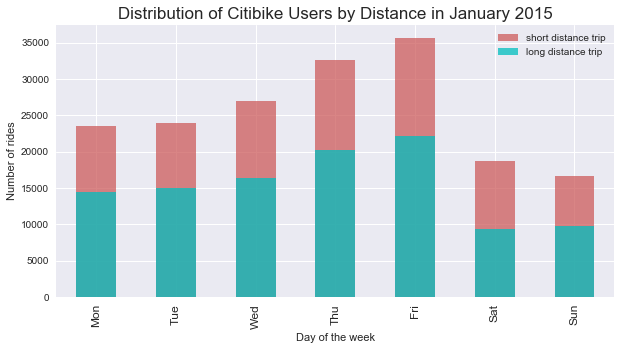

In [12]:
import pylab as pl
import seaborn as sns
fig = pl.figure(figsize(10,5))

norm_s = 1
((df['date'][df['distance'] < avg].groupby([df['date'].dt.weekday]).count()) / norm_s).plot(kind="bar", alpha=0.75,
                                                                                         color='IndianRed', 
                                                                                         label='short distance trip')

norm_l = 1
ax = ((df['date'][df['distance'] > avg].groupby([df['date'].dt.weekday]).count()) / norm_l).plot(kind="bar", 
                                                                                              color='c', 
                                                                                              alpha=0.75,
                                                                                              label='long distance trip')

tmp = ax.xaxis.set_ticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=12)
pl.xlabel('Day of the week')
pl.ylabel('Number of rides')
pl.title('Distribution of Citibike Users by Distance in January 2015', fontsize=17)
pl.legend()
pl.show()

> #### Figure 1a: Distribution of Citibike bikers by distance in January 2015, absolute counts

Note: the counts have errors of course. what is the error on the count statistics? 

for N counts the error is sqrt(N) - this is because counts follow a Poisson statistic

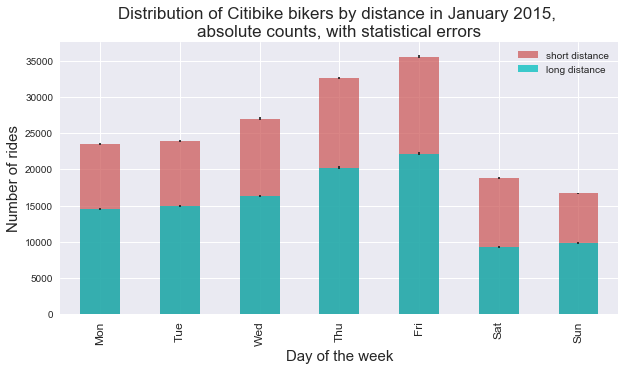

In [13]:
fig=pl.figure(figsize(10,5))

counts_s = df.date[df.distance < avg].groupby([df.date.dt.weekday]).count()
norm_s = 1
error_s = np.sqrt(counts_s)
ax=((counts_s) / norm_s).plot(kind="bar",color='IndianRed', alpha=0.75, yerr=[
            ((error_s) / norm_s, (error_s) / norm_s)], label='short distance')


counts_l = df.date[df.distance > avg].groupby([df.date.dt.weekday]).count()
norm_l = 1
error_l=np.sqrt(counts_l)
((counts_l) / norm_l).plot(kind="bar", alpha=0.75, yerr=[((error_l) / norm_l, (error_l) / norm_l)], 
                           color='c', label='long distance')
ax.xaxis.set_ticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], fontsize=12)
ax.set_ylabel ("Number of rides", fontsize=15)
ax.set_xlabel ("Day of the week", fontsize=15)
pl.legend(['short distance','long distance'],fontsize=10)
pl.title('Distribution of Citibike bikers by distance in January 2015, \nabsolute counts, with statistical errors', fontsize=17)
pl.show()

> #### Figure 1b: Distribution of Citibike bikers by gender in January 2015, absolute counts, with statistical errors

Note: These are absolute numbers. It is very hard to compare absolute numbers. Ratios (or proportions) are more ameable to comparison, so let's _normalize_ the distribution of short distance, and that of longs distance, i.e. devide them by the total number of rides for that days. 
(Notice that i have to normalize the errorbars too!)



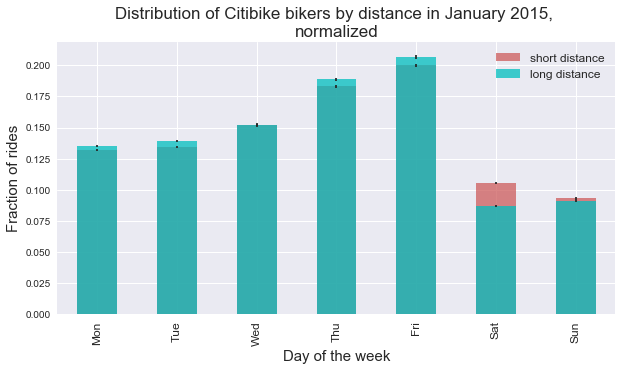

In [14]:
fig = pl.figure(figsize(10,5))

norm_s = counts_s.sum()
error_s = np.sqrt(counts_s)
((counts_s) / norm_s).plot(kind="bar", color='IndianRed', alpha=0.75, 
                           yerr=[((error_s) / norm_s, (error_s) / norm_s)], 
                           label='short distance')

norm_l = counts_l.sum()
ax = ((counts_l) / norm_l).plot(kind="bar", alpha=0.75, 
                                yerr=[((error_l) / norm_l, (error_l) / norm_l)], 
                                color='c', label='long distance')

ax.xaxis.set_ticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=12)
ax.set_ylabel ("Fraction of rides", fontsize=15)
ax.set_xlabel ("Day of the week", fontsize=15)
pl.title('Distribution of Citibike bikers by distance in January 2015, \nnormalized', fontsize=17)
pl.legend(fontsize=12)
pl.show()

> #### Figure 2: Distribution of Citibike bikers by distance in January 2015, normalized

Long Distance: week:0.82, weekend:0.18, weekend error:0.00, weekend error:0.00
Short Distance: week:0.80, weekend:0.20, weekend error:0.00, weekend error:0.00


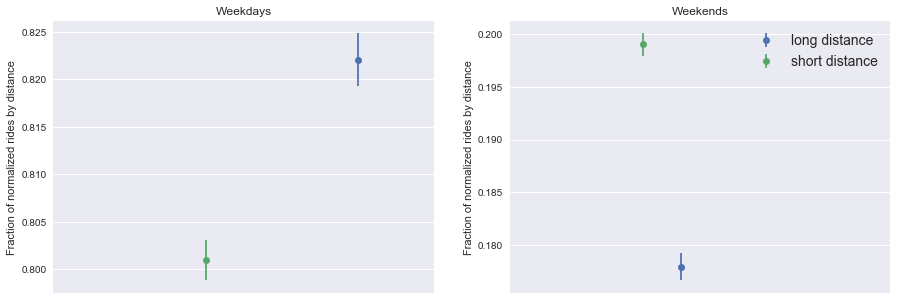

In [15]:
fig = pl.figure(figsize(15,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_xticks([])
ax2.set_xticks([])

# short distance
week_s = sum(counts_s[:-2]) * 1.0 / norm_s  #fraction of short distance trips on week days
weekend_s = sum(counts_s[-2:]) * 1.0 / norm_s  #fraction of short distance trips on weekends
eweek_s = np.sqrt(sum(error_s[:-2]**2)) / norm_s  #error on fraction number of short distance trips on week days
eweekend_s = np.sqrt(sum(error_s[-2:]**2)) / norm_s #error on fraction number of short distance trips on weekends

# long distance
week_l = sum(counts_l[:-2]) * 1.0 / norm_l
weekend_l = sum(counts_l[-2:]) * 1.0 / norm_l
eweek_l = np.sqrt(sum(error_l[:-2]**2)) / norm_l
eweekend_l = np.sqrt(sum(error_l[-2:]**2)) / norm_l

print("Long Distance: week:{0:.2f}, weekend:{1:.2f}, weekend error:{2:.2f}, weekend error:{3:.2f}"\
      .format(week_l, weekend_l, eweek_l, eweekend_l))
print("Short Distance: week:{0:.2f}, weekend:{1:.2f}, weekend error:{2:.2f}, weekend error:{3:.2f}"\
      .format(week_s, weekend_s, eweek_s, eweekend_s))

ax1.errorbar([0.4], [week_l], yerr=[eweek_l], fmt='o', label='long distance')
ax1.errorbar([0.2], [week_s], yerr=[eweek_s], fmt='o', label='short distance')
ax1.set_xlim(0, 0.5)
ax2.errorbar([0.4], [weekend_l], yerr=[eweekend_l], fmt='o', label='long distance')
ax2.errorbar([0.2], [weekend_s], yerr=[eweekend_s], fmt='o', label='short distance')
ax1.set_xlim(0, 0.5)
ax1.set_title("Weekdays")
ax2.set_title("Weekends")
ax2.set_ylabel("Fraction of normalized rides by distance")
ax1.set_ylabel("Fraction of normalized rides by distance")

pl.xlim(-0.5, 1.5)
pl.legend(fontsize = 14)

> #### Figure 3: Fraction of Citibike bikers per distance in January 2015 for weekdays (left) and weekends (right)

**Question :** Is the percentage of short distance trip on weekends lower or equal to that of long distance trip?

The statistics is: 

$z = \frac{(p_0 - p_1)}{SE} $

$p =\frac{p_0  n_0 + p_1  n_1}{n_0+n_1}$

$SE = \sqrt{ p  ( 1 - p )  (\frac{1}{n_0} + \frac{1}{n_1}) }$

and in this notation 

$p_0 = \frac{S_{\mathrm{weekend}}}{S_{\mathrm{total}}}$ and $p_1 = \frac{L_{\mathrm{weekend}}}{L_{\mathrm{total}}}$

In [16]:
P0mP1 = weekend_s - weekend_l
print ("difference between long distance trip and short distance trip on weekend: {:.3f}".format(P0mP1))
if P0mP1 <= 0:
    # we are done...
    print("In accordance with Null Hypothesis")
else:
    # morework to do
    print ("We must check the significance before we reject the Null Hypothesis")

difference between long distance trip and short distance trip on weekend: 0.021
We must check the significance before we reject the Null Hypothesis


In [17]:
# variable
p0 = weekend_s
p1 = weekend_l
n0 = norm_s
n1 = norm_l
# calculation
p = (p0 * n0 + p1 * n1) / (n0 + n1)
s = (p * (1 - p) * (1.0 / n0 + 1.0 / n1)) #standard error
se = np.sqrt(s)
zscore = (p0 - p1) / se

In [18]:
print ("The z statistics is %.2f"%zscore) 

The z statistics is 13.90


In [21]:
def ztest1tail(pvalue, z):
    "One tail: p value is 1 - alpha"
    zcritical = st.norm.ppf(pvalue)
    print ("Z critical value when P ({}) = {:.3f}".format(pvalue, zcritical))
    print ("Z-statistics is {:.3f}".format(z))
    if z >= zcritical:
        print ("Null hypothesis is rejected")
    else:
        print ("Null hypothesis is accepted")

In [22]:
ztest1tail(0.95,zscore)

Z critical value when P (0.95) = 1.645
Z-statistics is 13.902
Null hypothesis is rejected


### Crosscheck
Because I use dataset in January, which is winter season (extreme weather, where the chance of citibike usage will be lower than any other season), I need to crosscheck the result with the summer season. In this part, I will check with dataset from July 2015.

In [23]:
# download data
url2 = urlopen('https://s3.amazonaws.com/tripdata/201507-citibike-tripdata.zip')
df2 = pd.read_csv(io.BytesIO(url2.read()), compression='zip', sep=',')
# set date
df2['date'] = pd.to_datetime(df2['starttime'])
# drop unnecessary columns
df2.drop(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'end station id', 'end station name', 'bikeid', 'usertype',
       'birth year'], axis=1, inplace=True)
# merge and drop location data
df2.loc[:,"start_location"] = "(" + df2["start station latitude"].map(str) + "," + " " + df2["start station longitude"].map(str) + ")"
df2.loc[:,"stop_location"] = "(" + df2["end station latitude"].map(str) + "," + " " + df2["end station longitude"].map(str) + ")"
df2.loc[:,"start_location"] = df2.loc[:,"start_location"].map(eval)
df2.loc[:,"stop_location"] = df2.loc[:,"stop_location"].map(eval)
df2.drop(['start station latitude', 'start station longitude',
       'end station latitude', 'end station longitude'], axis=1, inplace=True)
def distance(df2):
    return vincenty(df2["start_location"],df2["stop_location"]).miles
df2["distance"] = df2.apply(distance, axis=1)
df2.head(2)

,gender,date,start_location,stop_location,distance
0,1,2015-07-01 00:00:03,"(40.75066386, -74.00176802)","(40.73038599, -74.00214988)",1.399369
1,1,2015-07-01 00:00:06,"(40.70463334, -74.01361706)","(40.711512, -74.01575600000001)",0.487750


In [24]:
df2.distance.describe()

count    1.085676e+06
mean     1.078495e+00
std      7.766540e-01
min      0.000000e+00
25%      5.413206e-01
50%      8.764121e-01
75%      1.403145e+00
max      6.309904e+00
Name: distance, dtype: float64

In [25]:
# set threshold
avg2 = df2.distance.mean()

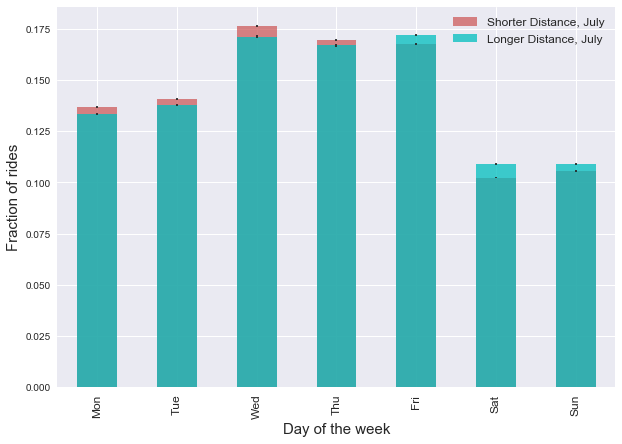

In [26]:
fig=pl.figure(figsize(10,7))

counts_s07 = df2.date[df2.distance < avg2].groupby([df2.date.dt.weekday]).count()
norm_s07 = counts_s07.sum()
error_s07 = np.sqrt(counts_s07)

((counts_s07) / norm_s07).plot(kind="bar",color='IndianRed', alpha=0.75,  yerr=[
((error_s07) / norm_s07, (error_s07) / norm_s07)], label='Shorter Distance, July')

counts_l07 = df2.date[df2.distance > avg2].groupby([df2.date.dt.weekday]).count()
norm_l07 = counts_l07.sum()
error_l07 = np.sqrt(counts_l07)
ax=((counts_l07) / norm_l07).plot(kind="bar", alpha=0.75, 
                                  yerr=[((error_l07) / norm_l07, (error_l07) / norm_l07)], 
                                  color="c", label='Longer Distance, July')
ax.xaxis.set_ticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], fontsize=12)
ax.set_ylabel ("Fraction of rides", fontsize=15)
ax.set_xlabel ("Day of the week", fontsize=15)

pl.legend(fontsize=12)

> #### Figure 4. Distribution of Citibike bikers by distance in July 2015, normalized

Longer distance: 
week:0.782, 
weekend:0.218, 
weekdays error:0.001, 
weekend error:0.001

Shorter distance: 
week:0.792, 
weekend:0.208, 
weekdays error:0.001, 
weekend error:0.001


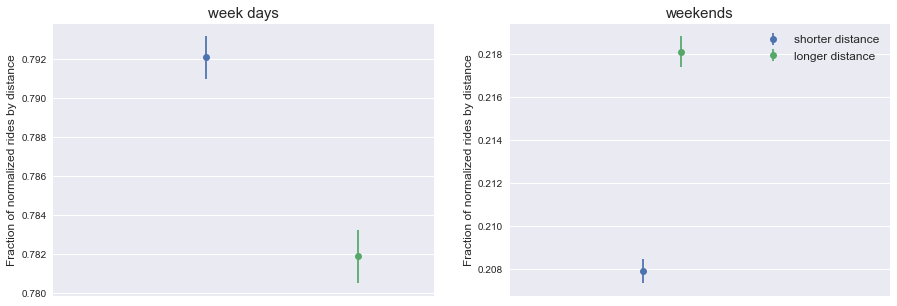

In [27]:
fig=pl.figure(figsize(15,5))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)
ax1.set_xticks([])
ax2.set_xticks([])

week_s07 = sum(counts_s07[:-2]) * 1.0 / norm_s07
weekend_s07 = sum(counts_s07[-2:])*1.0 / norm_s07
eweek_s07 = np.sqrt(sum(error_s07[:-2]**2)) / norm_s07
eweekend_s07 = np.sqrt(sum(error_s07[-2:]**2)) / norm_s07

week_l07 = sum(counts_l07[:-2]) * 1.0 / norm_l07
weekend_l07 = sum(counts_l07[-2:]) * 1.0 / norm_l07
eweek_l07 = np.sqrt(sum(error_l07[:-2]**2)) / norm_l07
eweekend_l07 = np.sqrt(sum(error_l07[-2:]**2)) / norm_l07

print("Longer distance: \nweek:{0:.3f}, \nweekend:{1:.3f}, \nweekdays error:{2:.3f}, \nweekend error:{3:.3f}"\
      .format(week_l07, weekend_l07, eweek_l07, eweekend_l07))
print("\nShorter distance: \nweek:{0:.3f}, \nweekend:{1:.3f}, \nweekdays error:{2:.3f}, \nweekend error:{3:.3f}"\
      .format(week_s07, weekend_s07, eweek_s07, eweekend_s07))

ax1.errorbar([0.2],[week_s07], yerr=[eweek_s07], fmt='o', label='shorter distance')
ax1.errorbar([0.4],[week_l07], yerr=[eweek_l07], fmt='o', label='longer distance')
ax1.set_xlim(0,0.5)
ax2.errorbar([0.2],[weekend_s07], yerr=[eweekend_s07], fmt='o', label='shorter distance')
ax2.errorbar([0.4],[weekend_l07], yerr=[eweekend_l07], fmt='o', label='longer distance')
ax1.set_xlim(0,0.5)
ax1.set_title("week days", fontsize=15)
ax2.set_title("weekends", fontsize=15)
ax2.set_ylabel("Fraction of normalized rides by distance", fontsize=12)
ax1.set_ylabel("Fraction of normalized rides by distance", fontsize=12)

pl.xlim(-0.5,1.5)
pl.legend(fontsize=12)

> #### Figure 5: Fraction of Citibike bikers per distance in July 2015 for weekdays (left) and weekends (right)

In [28]:
# difference
P0mP1_07 = weekend_s07 - weekend_l07
print ("difference between long distance trip and short distance trip on weekend: {:.3f}".format(P0mP1_07))
if P0mP1_07 <= 0:
    # we are done...
    print("In accordance with Null Hypothesis")
else:
    # morework to do
    print ("We must check the significance before we reject the Null Hypothesis")

# variable
p0_07 = weekend_s07
p1_07 = weekend_l07
n0_07 = norm_s07
n1_07 = norm_l07

# calculation
p_07 = (p0_07 * n0_07 + p1_07 * n1_07) / (n0_07 + n1_07)
s_07 = (p_07 * (1 - p_07) * (1.0 / n0_07 + 1.0 / n1_07)) #standard error
se_07 = np.sqrt(s_07)
zscore_07 = (p0_07 - p1_07) / se_07

# Z test
ztest1tail(0.95,zscore_07)

difference between long distance trip and short distance trip on weekend: -0.010
In accordance with Null Hypothesis
Z critical value when P (0.95) = 1.645
Z-statistics is -12.641
Null hypothesis is accepted


In [29]:
rjanuary = zscore / np.sqrt(n0+n1)
rjuly = zscore_07 / np.sqrt(n0_07+n1_07)
print ("r in January: {:.3f}\nr in July: {:.3f}".format(rjanuary, rjuly))

r in January: 0.026
r in July: -0.012


In [30]:
hjanuary = 2 * (np.arcsin(np.sqrt(p0)) - np.arcsin(np.sqrt(p1)))
hjuly = 2 * (np.arcsin(np.sqrt(p0_07)) - np.arcsin(np.sqrt(p1_07)))
print ("h in January: {:.3f}\nh in July: {:.3f}".format(hjanuary, hjuly))

h in January: 0.054
h in July: -0.025
